# Import Modules
First import necessary modules.

In [1]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from IPython.display import display, clear_output, Javascript
import numpy as np
from ipywidgets import interact, Layout
import ipywidgets as widgets
import itertools
import pandas as pd
import networkx.algorithms.community as nxcom
from pylab import *

 Load the graph that was pickled in the previous notebook

In [2]:
with open('pickle/treasury.p', 'rb') as p: 
    G = pickle.load(p)
file = 'csv/treasury_shoes2.txt'
tr_df = pd.read_csv(file, encoding='utf8')
ids = list(tr_df['id_text'])
ids.sort()

# Visualization Functions
This function helps us find the proportional size of the node. By Colman Bouton.

In [3]:
def node_size_calculator(graph, property_name, minSize, maxSize):
    '''Given the graph, the property_name which we will use as a size reference, 
     and the minSze and maxSize, calculate the relative size of the nodes'''
    node_data = graph.nodes.data(data=property_name)
    data_max = max([v for k,v in node_data])
    data_min = min([v for k,v in node_data])
    return {k: int(minSize + v/(data_max-data_min)*(maxSize-minSize)) 
          for k,v in node_data}

There are several things that are key to creating good positioning for a graph visualization using the spring layout. First, we must use an undirected version of the graph for spring calculations. Otherwise, nodes that have a single directed edge leading into them will not be attracted to any other node and simply fly off.

Additionally, unless the user specifies otherwise, we use the degree of the two nodes of an edge to weaken the strength of the spring. Generally, since degree represents the number of visual features around a node, this will produce the best visualisation.

A further consideration to be had is that if the graph is not connected, its components will fly away from each other without bound. Therefore, it is essential for any graph you might be drawing with spring_layout that it is connected. We will be addressing this issue in our own graph at a later step.

Function by Colman Bouton

In [4]:
def spring_position_calculator(graph, weight_property_name = None, 
                               spring_seed = None):

    gcopy = graph.to_undirected()

    if weight_property_name == None:
        weight_property_name = 'degree'
        for node in gcopy.nodes:
            gcopy.nodes[node]['degree'] = gcopy.degree[node]
  
    avg_weight = np.median([v for k,v in gcopy.nodes().data(data = weight_property_name)]) #used for draw weight calculation
    overall_reduce = 1 / gcopy.number_of_nodes()**0.5
    for edge in gcopy.edges:
    #calculate draw_weight for each edge
        gcopy[edge[0]][edge[1]]['draw_weight'] = overall_reduce * avg_weight * gcopy[edge[0]][edge[1]]['weight'] / (min(gcopy.nodes[edge[0]][weight_property_name], 
                                                                                                                        gcopy.nodes[edge[1]][weight_property_name]) + 0.01 * avg_weight)
  
    pos = nx.spring_layout(gcopy, weight = 'draw_weight', 
                         iterations = 500, seed=spring_seed)
    return pos

Now we can put all this to together and create a function that draws a pretty graph! We will default to using a spring graph, as well as taking in some arguments that will allow us to parameterize the size of the nodes and input which metric we will use to color code the nodes with.

Function by Colman Bouton.

In [5]:
def draw_pretty_graph(graph, minSize, maxSize,
                            size_attr_name, figure, color_attr_name = 'degree',
                            spacing_attr_name = None, label_name = None, pos = None, 
                            label_cutoff = 1, spring_seed = None, Ego=None):
    '''Draw a pretty graph using the graph argument and resize the nodes using the
     minSize and maxSize argments, while coloring the nodes by a determined metric'''
  
  # first, we use our previously defined function to create a dict for the sizes
    node_sizes = node_size_calculator(graph, size_attr_name, minSize, maxSize)

  # then we create the list of values for our colormap
    color_values = list(nx.get_node_attributes(graph, color_attr_name).values())
    v_min = min(color_values)
    v_max = max(color_values)

  # if positions are not specified, calculate them using the previous function
    if pos == None:
        pos = spring_position_calculator(graph, spacing_attr_name)

    # we now position the labels:
    label_pos = {}
    num_labels = int(G.number_of_nodes() * label_cutoff) # calculate number of labels to show
    for node in sorted(node_sizes, key = node_sizes.get, reverse=True)[0:num_labels]:
      # set the label position to be slightly offset from the node position
        label_pos[node] = [pos[node][0], pos[node][1] + 0.03]
    if Ego:
        label_pos[Ego] = [pos[Ego][0], pos[Ego][1] + 0.03]

  # draw nodes and edges
    nx.draw_networkx_nodes(        
          graph,
          pos,
          node_size = [node_sizes[node] for node in graph],
          node_color= color_values,
          alpha = 1,
          cmap= plt.cm.plasma, 
          vmax = v_max,
          vmin = v_min,
          )
    nx.draw_networkx_edges(        
          graph,
          pos,
          node_size = [node_sizes[node] for node in graph],
          alpha = 0.5,
          edge_color = 'brown',
          width = 2,
          connectionstyle="arc3,rad=0.1"
          )
  
  # draw labels if provided
    if label_name == None:
        nx.draw_networkx_labels(graph, label_pos, 
                            font_size = 10, font_weight = 'bold') #, ax = ax)
    elif label_name != False: #if label_name is False, dont't draw labels
        labels = {k:graph.nodes.data(data = label_name)[k] for k in label_pos}
        nx.draw_networkx_labels(graph, label_pos, labels = labels, 
                            font_size = 14, font_weight = 'bold', 
                            font_color = 'black') #, ax = ax)
    
  # draw the colorbar
    norm = mpl.colors.Normalize(vmin = v_min, vmax = v_max)
    options = {'label' : color_attr_name}
    figure.colorbar(mpl.cm.ScalarMappable(norm, plt.cm.plasma), **options)

# Visualizing the Graph
Generally speaking, we found setting the edges to be transparent made the graph easier to read, and that making the graph sufficiently large helped us see the individual nodes.

We also chose to color code the nodes based on an assignable metric, which we defaulted to node degree. This makes it easier to discern which nodes are more important. We added a colorbar as a legend for the metric.

In spring graphs, the nodes are set to pull apart from each other and the edges act as springs pulling the nodes together. When the positions are being calculated, the repellant forces and the attractant forces through the springs are added up over a series of iterations until the graph settles into a particular set of positions. In some cases, when there is a large set of data, you might see the nodes clump together, making the nodes difficult to interpret individually.

Here we take the largest connected subgraph and use the `draw_pretty_graph` helper function to draw our network using a spring graph. 

Most of the nodes in our graph are pretty small, meaning they have a pretty low degree, but we see some interesting main actors. These nodes end up at the center of our graph because they are fairly well connected and thus are only pulled apart by less connected nodes.

By Colman Bouton

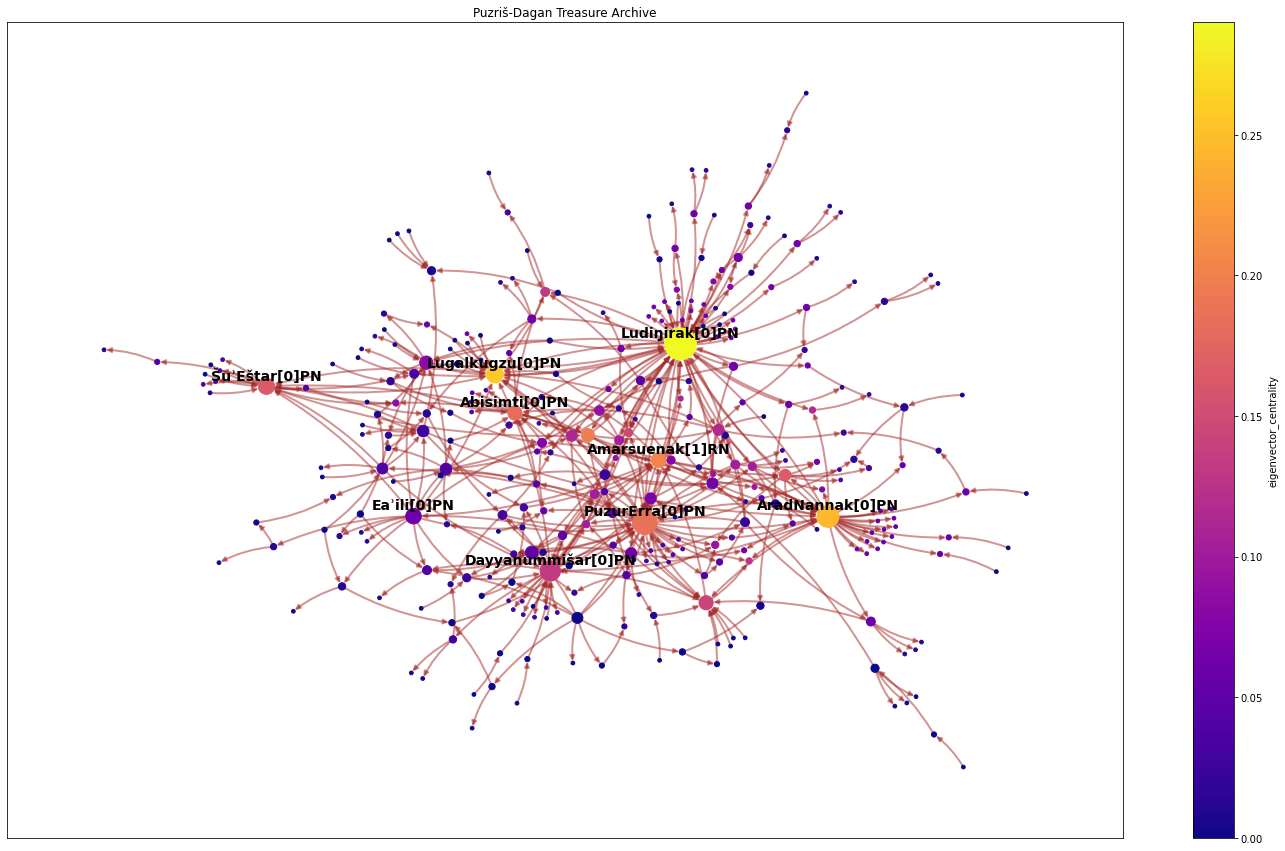

In [6]:
# remove nodes which have no connections to other nodes in the graph
mainc = max(nx.algorithms.components.connected_components(G.to_undirected()), 
            key = len)
I = G.subgraph(mainc).copy()
#degreelog = {name : np.log(I.degree[name]) for name in I.nodes}
#nx.set_node_attributes(I, degreelog, "degreelog")

# draw the graph using draw_pretty_graph helper function

figure = plt.figure(figsize=(25, 15))
draw_pretty_graph(I, 1, 1000, "degree", figure,
                  color_attr_name = 'eigenvector_centrality',
                  label_name = 'name', label_cutoff = 0.03, spring_seed=1);
plt.title('Puzriš-Dagan Treasure Archive');

# Import Bokeh

In [7]:
from bokeh.io import output_file, show
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool,
                         BoxZoomTool, ResetTool, OpenURL, CustomJS, Column, SaveTool, 
                         GraphRenderer, StaticLayoutProvider, LabelSet, ColumnDataSource)
from bokeh.palettes import Spectral4, Spectral6, Spectral8
from bokeh.plotting import figure, output_notebook, from_networkx
from bokeh.models import TextInput, Button
output_notebook()

Loading BokehJS ...

In [ ]:
pos = spring_position_calculator(I, "eigenvector_centrality")
node_sizes = node_size_calculator(I, "eigenvector_centrality", 1, 30)
start = [i[0] for i in I.edges]
end = [i[1] for i in I.edges]
nodes = [i[1] for i in I.nodes(data=True)]    
node_dict = {k: [dic[k] for dic in nodes] for k in nodes[0]} # this transform the networkx node attributes into
                                                            # a proper Bokeh data source
node_dict['index'] = node_dict['name']
node_size = [node_sizes[name] for name in node_dict['index']]
node_dict['size'] = node_size
edges = [i[2] for i in I.edges(data=True)]
edge_dict = {k: [dic[k] for dic in edges] for k in edges[0]}
edge_dict['start'] = start
edge_dict['end'] = end

In [ ]:
add_labels = sorted(node_sizes, key=node_sizes.get, reverse=True)[:10]
node_dict['labels'] = [n if n in add_labels else '' for n in node_dict['name']]

In [ ]:
plot = Plot(plot_width=1200, plot_height=900,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
plot.title.text = "Treasure Archive Drehem"

node_hover_tool = HoverTool(tooltips=[("name", "@name"), ("eigenvector centrality", "@eigenvector_centrality"), ("degree", '@degree')])
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool())

graph = GraphRenderer()
graph.node_renderer.glyph = Circle(size='size', fill_color='#2b83ba')
graph.node_renderer.hover_glyph = Circle(size='size', fill_color='#abdda4')
graph.layout_provider = StaticLayoutProvider(graph_layout=pos)
#graph.node_renderer.glyph = Circle(size = 'size', fill_color=Spectral4[0])
#graph.edge_renderer.glyph = MultiLine(line_color=Spectral4[1], line_alpha=0.8, line_width=3)

graph.edge_renderer.glyph = MultiLine(line_alpha=.2, line_width='weight')  # zero line alpha
graph.edge_renderer.hover_glyph = MultiLine(line_color='#abdda4', line_width=5)

#graph.selection_policy = NodesAndLinkedEdges()
graph.inspection_policy = NodesAndLinkedEdges()

plot.renderers.append(graph)

graph.edge_renderer.data_source.data = edge_dict
graph.node_renderer.data_source.data = node_dict

x, y = zip(*pos.values())
#node_labels = labels
source = ColumnDataSource({'x': x, 'y': y, 'name': [node_dict['labels'][i] for i in range(len(x))]})
labels = LabelSet(x='x', y='y', text='name', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.7)
plot.renderers.append(labels)

#output_file("interactive_graphs.html")
show(plot)

# Cliques
Cliques are sets of nodes that are all connected to each other. That is, if we have four nodes, A, B, C, and D, all possible connections exist: 
> A --- B</br>
> A --- C</br>
> A --- D</br>
> B --- C</br>
> B --- D</br>
> C --- D</br>

Cliques may represent powerful centers in a graph, with  information flowing freely within each clique. Cliques are defined only for undirected graphs, so we first have to transform our graph. In order to compute cliques we need to decide the minimum number of nodes - in this case 4.
See https://orbifold.net/default/community-detection-using-networkx/

A related concept is the k-clique community. A k-clique community consists of adjacent cliques of at least *k* members. Adjacent cliques share at least *k-1* nodes. As we will see, k-clique communities tend to overlap. That is, there are powerful actors who belong to multiple such communities and connect them to each other.

The following code needs more documentation.

The output of k_clique_communities() is a list of frozen sets. The clique communities are sorted from largest to smallest.

In [8]:
H = nx.DiGraph.to_undirected(G)
k_clique_com = sorted(nxcom.k_clique_communities(H, 4), key=len, reverse=True)
# Count the communities
N = len(k_clique_com)
print(f"The graph has {N} clique communities.")

The graph has 4 clique communities.


Each node in the graph receives an attribute called `cliques`. The default is `{0}` (a set). In iterating through the nodes in the clique communities, the attribute `cliques` is updated so that all nodes that belong to the first k-clique community now have the attribute `cliques = {1}` (again, a set), etc. Nodes that belong to more than one clique community will have more than one clique number in the `cliques` attribute (for instance `{1, 3}`). Nodes that are not found in any clique community will keep the default value `{0}`. We will use this attribute below to color nodes and to mark internal edges (edges between nodes that belong to the same clique).

In [9]:
nx.set_node_attributes(H, {0}, "cliques") # set {0} as default
for c, v_c in enumerate(k_clique_com):
    for v in v_c:
        if min(H.nodes[v]['cliques']) > 0:  # node is already in a clique
            H.nodes[v]['cliques'].add(c+1) # add clique no. to the set
        else:
            H.nodes[v]['cliques'] = {c+1}
        # Add 1 to save 0 for nodes that are not in a clique
            

Set edge attributes with the same method. The edge attribute `clique` defaults to zero. Edges between two nodes that belong to the same clique (internal edges) receive the value of that clique. This is done by finding the intersection of the `cliques` attributes of the two nodes. If that intersection is empty (the two nodes do not share membership of a clique community) the value remains 0. If the `cliques` attributes of two nodes do intersect (that is, they share membership of at least one k-clique community), the value of the edge attribute becomes the lowest value in the intersection.

In [10]:
nx.set_edge_attributes(H, 0, "clique")  # default is 0
for v, w, in H.edges:
    c = H.nodes[v]['cliques'].intersection(H.nodes[w]['cliques']) # do the two nodes share a community?
    if c:
        # Internal edge, mark with community
        H.edges[v, w]['clique'] = min(c)

Select nodes to display. Nodes that belong to a k-clique community and nodes that have a degree greater than 8 are admitted. Nodes that belong to one or more k-clique communities have a value in the attribute `cliques` that is higher than 0.

In [11]:
nodes = [x for x, y in H.nodes(data=True) if min(y["cliques"]) > 0 or y["degree"] > 8] # select nodes
K = H.subgraph(nodes)

For the color scheme we use a function for creating a discrete colormap, made available by Jake VanderPlas on his github account. The [tool](https://gist.github.com/jakevdp/91077b0cae40f8f8244a) is slightly adapted for the present purposes.

In [12]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map
    https://gist.github.com/jakevdp/91077b0cae40f8f8244a
    by Jake VanderPlas"""
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    color_list[0] = [0, 0, 0, 1] # = black
    color_list = [matplotlib.colors.rgb2hex(col) for col in color_list]
    return color_list

In [13]:
colmap = discrete_cmap(N+2, "jet")

In [14]:
colmap

['#000000', '#004cff', '#29ffce', '#ceff29', '#ff6800', '#800000']

Use the resulting colormap to assign node colors and edge colors of our subgraph.

In [15]:
#node_color = [colmap[min(K.nodes[v]['cliques'])] if len(K.nodes[v]['cliques'])==1 else colmap[N+1] for v in K.nodes]
#edge_color = [colmap[K.edges[v, w]['clique']] for v, w in K.edges]

In [16]:
labels = nx.get_node_attributes(K, 'name')

In [17]:
pos = spring_position_calculator(K, "eigenvector_centrality")
node_sizes = node_size_calculator(K, "eigenvector_centrality", 1, 30)
start = [i[0] for i in K.edges]
end = [i[1] for i in K.edges]
nodes = [i[1] for i in K.nodes(data=True)]    
node_dict = {k: [dic[k] for dic in nodes] for k in nodes[0]} # this transform the networkx node attributes into
                                                            # a proper Bokeh data source
node_dict['index'] = node_dict['name']
node_size = [node_sizes[name] for name in node_dict['index']]
node_dict['size'] = node_size
node_dict['cliques'] = [min(cliques) if len(cliques) == 1 else N+1 for cliques in node_dict['cliques']]
node_dict['node_color'] = [colmap[clique] for clique in node_dict['cliques']]
edges = [i[2] for i in K.edges(data=True)]
edge_dict = {k: [dic[k] for dic in edges] for k in edges[0]}
edge_dict['start'] = start
edge_dict['end'] = end
edge_dict['edge_color'] = [colmap[clique] for clique in edge_dict['clique']]

In [18]:
add_labels = sorted(node_sizes, key=node_sizes.get, reverse=True)[:10]
node_dict['labels'] = [n if n in add_labels else '' for n in node_dict['name']]

In [20]:
plot = Plot(plot_width=1200, plot_height=900,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
plot.title.text = "Treasure Archive Drehem"

node_hover_tool = HoverTool(tooltips=[("name", "@name"), ("eigenvector centrality", "@eigenvector_centrality")])
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool())

graph = GraphRenderer()
graph.layout_provider = StaticLayoutProvider(graph_layout=pos)
graph.node_renderer.glyph = Circle(size='size', fill_color='node_color')
graph.node_renderer.hover_glyph = Circle(size='size', fill_color='#abdda4')

#graph.node_renderer.glyph = Circle(size = 'size', fill_color=Spectral4[0])
#graph.edge_renderer.glyph = MultiLine(line_color=Spectral4[1], line_alpha=0.8, line_width=3)

graph.edge_renderer.glyph = MultiLine(line_alpha=.2, line_width='weight', line_color='edge_color')  
graph.edge_renderer.hover_glyph = MultiLine(line_color='edge_color', line_width=5)

#graph.selection_policy = NodesAndLinkedEdges()
graph.inspection_policy = NodesAndLinkedEdges()

plot.renderers.append(graph)

graph.edge_renderer.data_source.data = edge_dict
graph.node_renderer.data_source.data = node_dict

x, y = zip(*pos.values())
node_labels = labels
source = ColumnDataSource({'x': x, 'y': y, 'name': [node_dict['labels'][i] for i in range(len(x))]})
labels = LabelSet(x='x', y='y', text='name', source=source, background_fill_color='white', text_font_size='14px', background_fill_alpha=.7)
plot.renderers.append(labels)

#output_file("interactive_graphs.html")
show(plot)